In [ ]:
! pip install split-folders

In [ ]:
# Import essential libraries
import kagglehub
import numpy as np
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy # A module that provides functions for creating copies of objects, useful for avoiding unintended modifications to variables.
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"abderrahimouahab","key":"beac998c0f612c656a8fcc736b4629ab"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
brian-tumor-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip brian-tumor-dataset.zip

Archive:  brian-tumor-dataset.zip
replace Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
replace Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
df = pd.read_csv('/content/metadata.csv')

In [ ]:
df

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"
...,...,...,...,...,...,...
4595,4595,Not Cancer (995).jpg,normal,JPEG,RGB,"(168, 300, 3)"
4596,4596,Not Cancer (996).jpg,normal,JPEG,RGB,"(509, 452, 3)"
4597,4597,Not Cancer (997).jpg,normal,JPEG,RGB,"(197, 177, 3)"
4598,4598,Not Cancer (998).jpg,normal,JPEG,RGB,"(217, 232, 3)"


In [ ]:
print(len(df[df["class"]=="tumor"]))
print(len(df[df["class"]=="normal"]))

2513
2087


### Définition du chemin du dataset et découpage

In [ ]:
# Dataset Path
data_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set'
# standardise le chemin pour la compatibilité multiplateforme
data_dir = pathlib.Path(data_dir)

# Découpe le dataset en deux parties: train_set, val_set
splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))


# New dataset path
data_dir = 'brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:01, 3906.12 files/s]


### Définition des transformations

In [ ]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((256,256)), # image à une taille fixe de 256x256 pixels
        # Permet au modèle d'apprendre à reconnaître les objets malgré des orientations inattendues
        transforms.RandomHorizontalFlip(p=0.5), # Retourne horizontalement l'image avec une probabilité de 50 %
        transforms.RandomVerticalFlip(p=0.5), # Retourne verticalement l'image avec une probabilité de 50 %
        transforms.RandomRotation(30), # Tourne l'image aléatoirement jusqu'à ±30 degrés
        transforms.ToTensor(),
        # Normalise les valeurs de pixels pour les ajuster à une distribution standard
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

### `transforms.ToTensor()` :

- **Conversion en tenseur PyTorch :**
  - Transforme les images en tenseurs PyTorch.
  - Les valeurs des pixels passent de l'échelle `[0, 255]` à `[0, 1]`.

- **Changement de format :**
  - Avant : `(hauteur, largeur, canaux)` .
  - Après : `(canaux, hauteur, largeur)` .

- **Pourquoi c'est important :**
  - Les modèles PyTorch nécessitent des tenseurs pour fonctionner.
  - Normaliser les pixels accélère l'entraînement.

### Chargement des datasets

In [ ]:
# Define an object of the custom dataset for the train and validation.

#Charge les images dans des objets ImageFolder, appliquant les transformations définies.

train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

train/
    Brain Tumor/
        image1.jpg
        image2.jpg
        ...
    Healthy/
        image1.jpg
        image2.jpg
        ...
val/
    Brain Tumor/
        image1.jpg
        image2.jpg
        ...
    Healthy/
        image1.jpg
        image2.jpg
        ...


In [ ]:
train_set

Dataset ImageFolder
    Number of datapoints: 3679
    Root location: brain/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# Vérifier les premières images du dataset
print(f"Nombre d'images dans le jeu d'entraînement : {len(train_set)}")
print(f"Nombre d'images dans le jeu de validation : {len(val_set)}")

Nombre d'images dans le jeu d'entraînement : 3679
Nombre d'images dans le jeu de validation : 921


### Visualisation des images

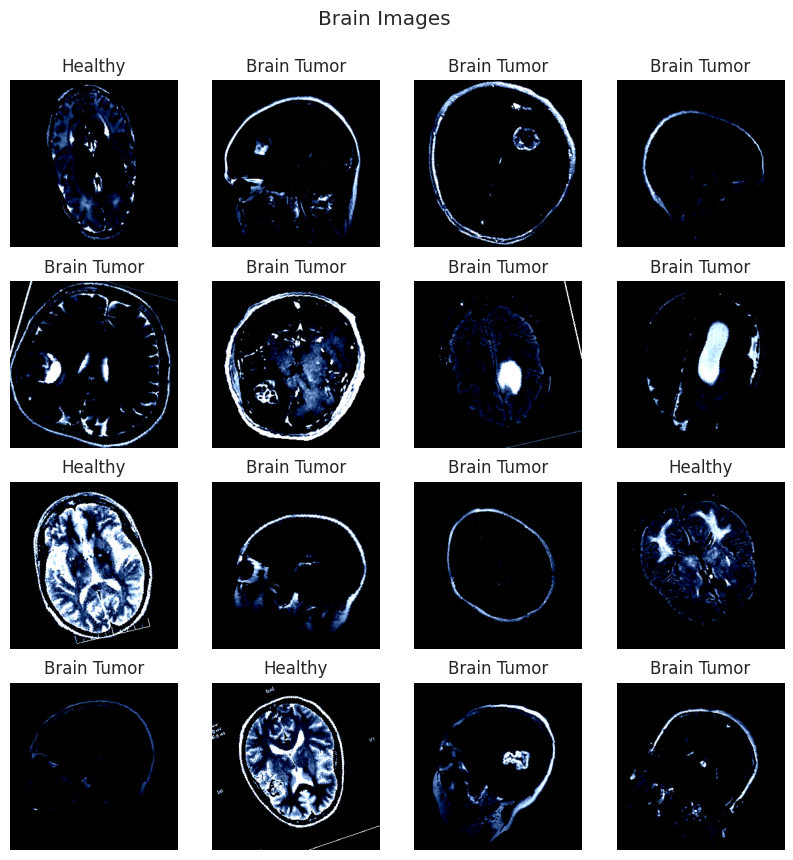

In [ ]:
# Visualiztion some images from Train Set
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

In [ ]:
# import and load train, validation
#DataLoader charge les données en batchs de taille 64, avec un mélange aléatoire (shuffle=True) pour diversifier les entrées
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)


In [ ]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



## Training data:
- Shape of X : torch.Size([64, 3, 256, 256])

 - 64 : Le nombre d'images dans un batch (défini par batch_size=64).
 - 3 : Le nombre de canaux d'une image, ici c'est une image couleur avec 3 canaux (rouge, vert, bleu pour RGB).
 - 256 : La hauteur de l'image (taille 256x256 pixels).
 - 256 : La largeur de l'image.


- Shape of y : torch.Size([64]) torch.int64

 - 64 : Le nombre de labels dans un batch, un pour chaque image.
   
Ce sont des entiers représentant les classes des images (par exemple, 0 pour "Brain Tumor" et 1 pour "Healthy").

## calculer les dimensions de sortie d'une couche convolutionnelle (aprés pooling)

In [ ]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

 Dilatation:
La dilatation permet au filtre de "s'étendre" entre les pixels de l'image, en insérant des espaces entre les éléments du noyau. Ce paramètre est très utile pour capturer des motifs sur de grandes échelles sans augmenter la taille du filtre lui-même.

## Définition du modèle CNN

In [ ]:
# Define Architecture For CNN_TUMOR Model

# nn.Module est la classe de base pour tous les modèles de réseaux de neurones dans PyTorch.
# Tous les modèles définis dans PyTorch doivent hériter de cette classe pour bénéficier
# des fonctionnalités et des outils nécessaires pour l'entraînement et l'évaluation d'un modèle.

class CNN_TUMOR(nn.Module):

    # Network Initialisation

    def __init__(self, params):

        super(CNN_TUMOR, self).__init__()

        Cin,Hin,Win = params["shape_in"] # la hauteur et la largeur de l'image d'entrée. Par exemple, pour une image RGB de taille 256x256, cela serait (3, 256, 256).
        init_f = params["initial_filters"] # Le nombre initial de filtres pour la première couche convolutionnelle.
        num_fc1 = params["num_fc1"]  # Le nombre de neurones dans la première couche entièrement connectée
        num_classes = params["num_classes"] # Le nombre de classes que le modèle doit prédire (dans ce cas, 2 classes : "Brain Tumor" et "Healthy").
        self.dropout_rate = params["dropout_rate"] #  Le taux de dropout appliqué dans le réseau pour éviter le surapprentissage.

        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    # PAV

    def forward(self,X):

        # Convolution & Pool Layers
        X = F.relu(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

1- Convolution et Activation : Les données passent successivement dans les couches convolutionnelles avec une activation ReLU après chaque convolution (F.relu).

2- Max Pooling : Après chaque convolution, une opération de pooling de taille 2x2 est effectuée pour réduire la taille des cartes de caractéristiques et augmenter l'invariance aux petites translations.

3- Aplatissement : Après les couches convolutionnelles et de pooling, les données sont "aplatie" en un vecteur 1D pour être passées dans les couches entièrement connectées.

4- Fully Connected Layers : Le vecteur aplati passe d'abord dans la couche entièrement connectée fc1, puis une couche de dropout est appliquée pour éviter le surapprentissage. Enfin, les données passent dans la couche finale fc2 pour produire les prédictions.

5- Softmax Logarithmique : F.log_softmax(X, dim=1) applique une fonction softmax aux sorties de la couche finale pour obtenir des probabilités, mais sous forme de log-probabilités, ce qui est souvent plus stable numériquement dans les tâches de classification.

# cree model

In [ ]:
params_model={
        "shape_in": (3,256,256),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = CNN_TUMOR(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [ ]:
# Model Summary for CNN Model
summary(cnn_model, input_size=(3, 256, 256),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
            Conv2d-2         [-1, 16, 125, 125]           1,168
            Conv2d-3           [-1, 32, 60, 60]           4,640
            Conv2d-4           [-1, 64, 28, 28]          18,496
            Linear-5                  [-1, 100]       1,254,500
            Linear-6                    [-1, 2]             202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 7.11
Params size (MB): 4.88
Estimated Total Size (MB): 12.74
----------------------------------------------------------------


## Loss Function Definition

In [ ]:
loss_func = nn.NLLLoss(reduction="sum")

## Optimiser Definition

In [ ]:
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

## Training Model

In [ ]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

## Training Function

In [ ]:
def Train_Val(model, params,verbose=False):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    # history of loss values in each epoch
    loss_history={"train": [],"val": []}
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []}
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    # initialize best loss to a large value
    best_loss=float('inf')

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.)

    for epoch in tqdm(range(epochs)):

        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


# Train Model Process


        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)


# Evaluate Model Process


        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [ ]:
# Define various parameters used for training and evaluation of a cnn_model

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 60,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist = Train_Val(cnn_model,params_train)

  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Save Model

In [ ]:
torch.save(cnn_model, "Brain_Tumor_model.pt")

# TEST

upload model

In [ ]:
files.upload()

Saving testH.jpg to testH (2).jpg


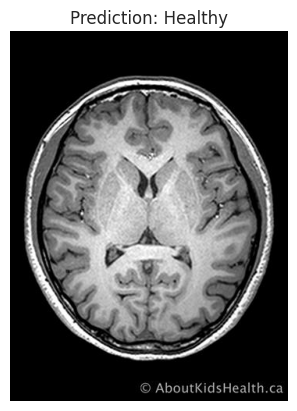

Predicted Class: Healthy


In [ ]:
# Function to upload and preprocess the image
def upload_and_predict(model, device):
    uploaded = files.upload()  # Upload the image

    # Assuming that only one file is uploaded
    for filename in uploaded.keys():
        # Open the image
        img = Image.open(filename).convert("RGB")

        # Apply the same transformations as in the training phase
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Transform the image
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

        # Make a prediction
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)

        # Get the predicted class (index of the maximum log-probability)
        _, predicted_class = torch.max(output.data, 1)

        # Map the predicted class to a label
        CLA_label = {0: 'Brain Tumor', 1: 'Healthy'}
        predicted_label = CLA_label[predicted_class.item()]

        # Display the image and prediction
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_label}")
        plt.axis('off')
        plt.show()

        print(f"Predicted Class: {predicted_label}")

# Charger le modèle sauvegardé
model = torch.load('/content/Brain_Tumor_model.pt', map_location=torch.device('cpu'))
# Test the function after the model is trained and saved
upload_and_predict(model, device)
